## **Preparando o Ambiente**

### **Apresentação**

### PySpark


PySpark é uma interface para Apache Spark em Python. Ele não apenas permite que você escreva aplicativos Spark usando APIs Python, mas também fornece o *shell* PySpark para analisar interativamente seus dados em um ambiente distribuído. O PySpark oferece suporte à maioria dos recursos do Spark, como Spark SQL, DataFrame, Streaming, MLlib (Machine Learning) e Spark Core.

<center><img src="https://caelum-online-public.s3.amazonaws.com/2273-introducao-spark/01/img-001.png"/></center>

#### **Spark SQL e DataFrame**

Spark SQL é um módulo Spark para processamento de dados estruturados. Ele fornece uma abstração de programação chamada DataFrame e também pode atuar como mecanismo de consulta SQL distribuído.

#### **Spark Streaming**

Executando em cima do Spark, o recurso de *streaming* no Apache Spark possibilita o uso de poderosas aplicações interativas e analíticas em *streaming* e dados históricos, enquanto herda a facilidade de uso do Spark e as características de tolerância a falhas.

#### **Spark MLlib**

Construído sobre o Spark, MLlib é uma biblioteca de aprendizado de máquina escalonável que fornece um conjunto uniforme de APIs de alto nível que ajudam os usuários a criar e ajustar *pipelines* de aprendizado de máquina práticos.

#### **Spark Core**

Spark Core é o mecanismo de execução geral subjacente para a plataforma Spark sobre o qual todas as outras funcionalidades são construídas. Ele fornece um RDD (*Resilient Distributed Dataset*) e recursos de computação na memória.

<font size=2>**Fonte:** [PySpark](https://spark.apache.org/docs/latest/api/python/index.html)</font>

### SparkSession


O ponto de entrada para programar o Spark com a API Dataset e DataFrame.

Uma SparkSession pode ser utilizada para criar DataFrames, registrar DataFrames como tabelas, executar consultas SQL em tabelas, armazenar em cache e ler arquivos parquet. Para criar uma SparkSession, use o seguinte padrão de construtor:

<font size=2>**Fonte:** [SparkSession](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.SparkSession.html)</font>

In [3]:
from pyspark.sql import SparkSession
import findspark

findspark.init()

In [4]:
spark = SparkSession.builder.master('local[*]').appName("Processamento de Linguagem Natural com Spark").config("spark.network.timeout", "600s") \
    .config("spark.executor.heartbeatInterval", "120s").getOrCreate()

In [5]:
spark

## **Carregamento dos Dados**

In [6]:
dados = spark.read.csv('./data/imdb-reviews-pt-br.csv', escape="\"", header=True, inferSchema=True)

In [7]:
dados.show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
| 11|Cage plays a drun...|Cage interpreta u...|      neg|
| 12|First of all, I w...|Primeiro de tudo,...|      neg|
| 13|So tell me - what...|Então me diga - q...|      neg|
| 14|A big disappointm...|Uma grande decepç...|      neg|
| 15|This film

In [8]:
dados.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [9]:
dados.count()

49459

In [10]:
dados.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      neg|24765|
|      pos|24694|
+---------+-----+



### **Word Cloud**

A nuvem de palavras é um recurso visual muito utilizado para entender as palavras mais frequentes de um texto. Aqui usaremos a própria biblioteca do Python `WordCloud`. 

A ideia é coletar as palavras usando *list comprehension* e aplicando a função `collect()` em uma [amostra](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.sample.html), já que esta função exige muitos recursos de processamento do spark.

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [12]:
amostras = dados.select('text_pt').sample(fraction=0.1, seed=101)
amostras.show()

+--------------------+
|             text_pt|
+--------------------+
|"Tokyo Eyes" fala...|
|Cage interpreta u...|
|Então me diga - q...|
|Isto é verdadeira...|
|A presa tem uma h...|
|Se você pegasse t...|
|CUIDADO SPOILER: ...|
|Eu estava ansioso...|
|Resumindo, meu gr...|
|Fiquei desapontad...|
|Este é de longe o...|
|OK, a caixa parec...|
|Eu nunca vou ente...|
|Quando o jovem in...|
|Descrever este fi...|
|Eu sei que é impo...|
|Deanna Troi nua! ...|
|esta é realmente ...|
|Eu gostei muito d...|
|Eu tinha visto es...|
+--------------------+
only showing top 20 rows



In [13]:
amostras = [amostra["text_pt"] for amostra in amostras.collect()]

In [14]:
wordcloud = WordCloud(collocations = False,
                        background_color = 'white',
                        width = 1200,
                        height = 400,
                        prefer_horizontal = True
                      ).generate(str(amostras))

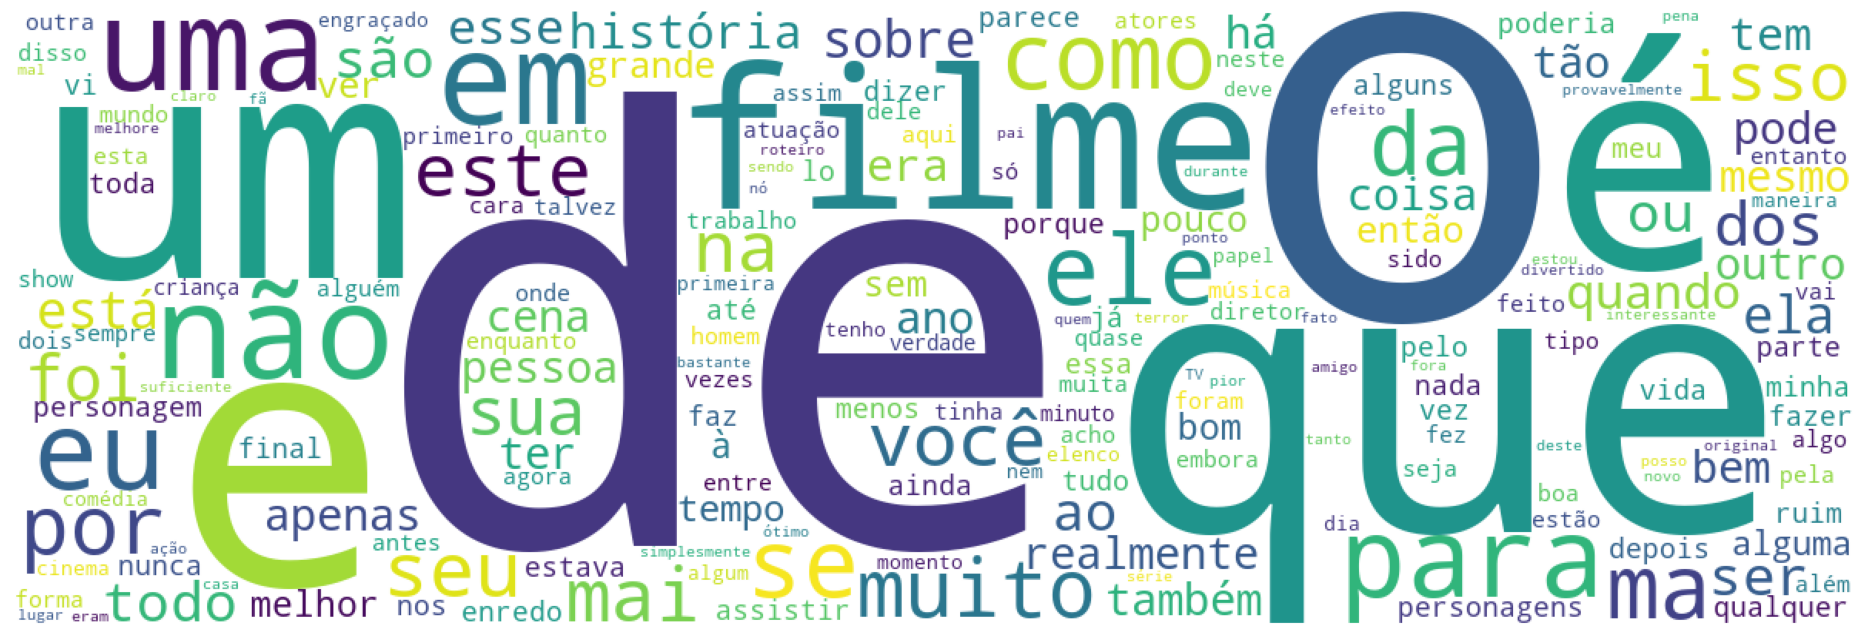

In [15]:
plt.figure(figsize=(24,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## **Pré-processamento dos Dados**


Para que o computador compreenda nossa linguagem é importante realizar algumas transformações no intuito de faciliar essa compreensão. Para isso, primeiramente podemos realizar a **limpeza dos dados**, que consiste na **remoção de caracteres que não contribui** na distinção dos sentimentos dos comentários dos nossos clientes, podemos citar por exemplos, remover caracteres especiais e espaços no início e fim dos comentários.


Logo após a limpeza de caracteres não relevantes, precisamos realizar o procedimento de **Tokenização**, que consiste no processo de **dividir uma frase** em palavras ou tokens (parte do texto) individuais.

E para finalizar o processamento dos nossos dados, iremos realizar a retirada de **stopwords**, ou seja, aquelas palavras que não auxiliam na classificação ou identificação do texto, em sua maioria são **preposições, artigos, pronomes .**..

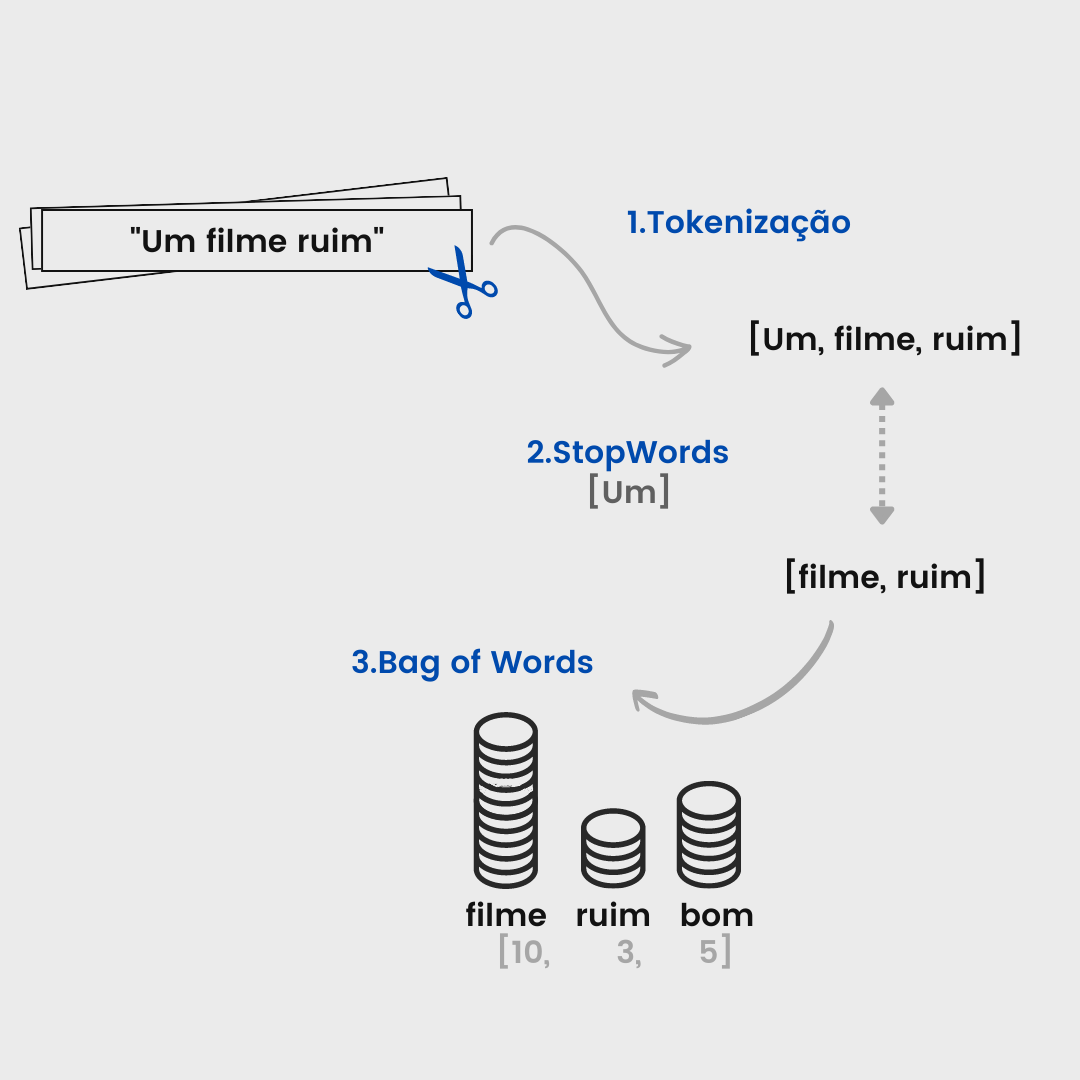

### **Limpeza**: caracteres especiais

In [16]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [17]:
from pyspark.sql import functions as f

In [18]:
dados = dados.withColumn("texto_regex", f.regexp_replace(f.col("text_en"), "[\$#,\"!%&'()*+-./:;<=>?@^_`´{|}~\\\\]", ""))
dados.limit(5).show()

+---+--------------------+--------------------+---------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|
+---+--------------------+--------------------+---------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|
+---+--------------------+--------------------+---------+--------------------+



In [19]:
dados = dados.withColumn("texto_limpo", f.trim(f.col("texto_regex")))
dados.limit(5).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|
+---+--------------------+--------------------+---------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|Not even the Beat...|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|Brass pictures mo...|
+---+--------------------+--------------------+---------+--------------------+--------------------+



### **Tokenização**: separação do texto em tokens

In [20]:
from pyspark.ml.feature import Tokenizer

In [21]:
tokenizer = Tokenizer(inputCol="texto_limpo", outputCol="tokens")

In [22]:
dados_tokenizados = tokenizer.transform(dados)

In [23]:
dados_tokenizados.limit(5).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|              tokens|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|[once, again, mr,...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|[this, is, an, ex...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|[first, of, all, ...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|Not even the Beat...|[not, even, the, ...|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|Brass pictures mo...|[brass, pictures,...|
+---+--------------------+------

In [24]:
dados_tokenizados = dados_tokenizados.withColumn("tokens_size", f.size(f.col("tokens")))

In [25]:
dados_tokenizados.limit(5).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+-----------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|              tokens|tokens_size|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+-----------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|[once, again, mr,...|        168|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|[this, is, an, ex...|        232|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|[first, of, all, ...|        215|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|Not even the Beat...|[not, even, the, ...|        308|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictur

### **StopWords**: remoção de ruídos


Podemos usar o [`StopWordsRemover()`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StopWordsRemover.html) nativo do spark, ou o [`stopwords()`](https://openbase.com/js/nltk-stopwords/documentation) da biblioteca nltk do Python. Dentre muitas linguagens, ambas bibliotecas dão suporte para o português.

In [26]:
from pyspark.ml.feature import StopWordsRemover

In [27]:
stopwords = StopWordsRemover.loadDefaultStopWords("english") 

In [28]:
swremover = StopWordsRemover(inputCol="tokens", outputCol="tokens_sem_stopwords", stopWords=stopwords)

In [29]:
dados_sem_stopwords = swremover.transform(dados_tokenizados)

In [30]:
dados_sem_stopwords.limit(5).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+-----------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|              tokens|tokens_size|tokens_sem_stopwords|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+-----------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|[once, again, mr,...|        168|[mr, costner, dra...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|[this, is, an, ex...|        232|[example, majorit...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|[first, of, all, ...|        215|[first, hate, mor...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat..

In [31]:
dados_sem_stopwords = dados_sem_stopwords.select("sentiment", "texto_limpo", "tokens", "tokens_sem_stopwords")\
    .withColumn("tokens_size", f.size(f.col("tokens")))\
    .withColumn("tokens_sem_stopwords_size", f.size(f.col("tokens_sem_stopwords")))

In [32]:
dados_sem_stopwords.show()

+---------+--------------------+--------------------+--------------------+-----------+-------------------------+
|sentiment|         texto_limpo|              tokens|tokens_sem_stopwords|tokens_size|tokens_sem_stopwords_size|
+---------+--------------------+--------------------+--------------------+-----------+-------------------------+
|      neg|Once again Mr Cos...|[once, again, mr,...|[mr, costner, dra...|        168|                       73|
|      neg|This is an exampl...|[this, is, an, ex...|[example, majorit...|        232|                      131|
|      neg|First of all I ha...|[first, of, all, ...|[first, hate, mor...|        215|                      111|
|      neg|Not even the Beat...|[not, even, the, ...|[even, beatles, w...|        308|                      169|
|      neg|Brass pictures mo...|[brass, pictures,...|[brass, pictures,...|        238|                      140|
|      neg|A funny thing hap...|[a, funny, thing,...|[funny, thing, ha...|        115|          

### **Vetorização**

A vetorização dos dados permite transformá-los da linguagem humana e não estruturada para uma maneira mais compreensível ao computador, ou seja, **codificando em números**, sendo possível assim associar cada um dos textos a um sentido e significado delimitados. 


O **Bag of Words**, ou sacola de palavras em português, é uma lista que contém todas as palavras que estão nos textos de maneira não repetida e tem papel importante para **identificar as palavras mais recorrentes** e entender se elas agregam algum sentimento.


Aqui no spark o bag of words não é representado por uma matriz do vocabulário como no python, e sim com uma estrutura específica que cria uma **estrutura especifica** que faciliar a compreensão nos modelos. 

Alternativas para vetorização: matriz_esparsa, countvectorizer, Hashing TF...

In [33]:
from pyspark.ml.feature import CountVectorizer

In [34]:
cv = CountVectorizer(inputCol="tokens_sem_stopwords", outputCol="features_cv").fit(dados_sem_stopwords)

In [35]:
dados_vetorizados_cv = cv.transform(dados_sem_stopwords)

In [36]:
dados_vetorizados_cv.show()

+---------+--------------------+--------------------+--------------------+-----------+-------------------------+--------------------+
|sentiment|         texto_limpo|              tokens|tokens_sem_stopwords|tokens_size|tokens_sem_stopwords_size|         features_cv|
+---------+--------------------+--------------------+--------------------+-----------+-------------------------+--------------------+
|      neg|Once again Mr Cos...|[once, again, mr,...|[mr, costner, dra...|        168|                       73|(216710,[0,7,8,11...|
|      neg|This is an exampl...|[this, is, an, ex...|[example, majorit...|        232|                      131|(216710,[1,2,3,8,...|
|      neg|First of all I ha...|[first, of, all, ...|[first, hate, mor...|        215|                      111|(216710,[0,2,4,11...|
|      neg|Not even the Beat...|[not, even, the, ...|[even, beatles, w...|        308|                      169|(216710,[0,1,2,4,...|
|      neg|Brass pictures mo...|[brass, pictures,...|[brass, p

#### **Hashing TF**: Vetorização com limite de vocabulário

In [37]:
from pyspark.ml.feature import HashingTF

In [38]:
dados_vetorizados_htf = HashingTF(inputCol="tokens_sem_stopwords", outputCol="features_htf", numFeatures=1000).transform(dados_sem_stopwords)

In [39]:
dados_vetorizados_htf.limit(5).show()

+---------+--------------------+--------------------+--------------------+-----------+-------------------------+--------------------+
|sentiment|         texto_limpo|              tokens|tokens_sem_stopwords|tokens_size|tokens_sem_stopwords_size|        features_htf|
+---------+--------------------+--------------------+--------------------+-----------+-------------------------+--------------------+
|      neg|Once again Mr Cos...|[once, again, mr,...|[mr, costner, dra...|        168|                       73|(1000,[10,21,34,4...|
|      neg|This is an exampl...|[this, is, an, ex...|[example, majorit...|        232|                      131|(1000,[0,3,11,12,...|
|      neg|First of all I ha...|[first, of, all, ...|[first, hate, mor...|        215|                      111|(1000,[1,7,33,38,...|
|      neg|Not even the Beat...|[not, even, the, ...|[even, beatles, w...|        308|                      169|(1000,[0,3,10,12,...|
|      neg|Brass pictures mo...|[brass, pictures,...|[brass, p

#### **TF-IDF**: Aplicando pesos à vetorização

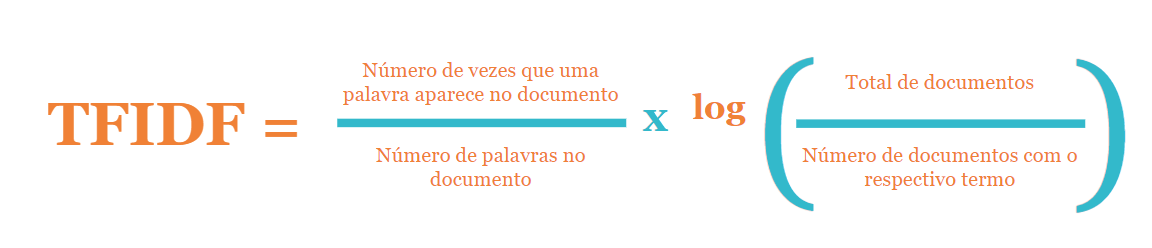

In [40]:
from pyspark.ml.feature import IDF

In [41]:
idf = IDF(inputCol="features_cv", outputCol="features").fit(dados_vetorizados_cv)

In [42]:
dados_vetorizados_com_peso = idf.transform(dados_vetorizados_cv)

In [43]:
dados_vetorizados_com_peso.limit(5).show()

+---------+--------------------+--------------------+--------------------+-----------+-------------------------+--------------------+--------------------+
|sentiment|         texto_limpo|              tokens|tokens_sem_stopwords|tokens_size|tokens_sem_stopwords_size|         features_cv|            features|
+---------+--------------------+--------------------+--------------------+-----------+-------------------------+--------------------+--------------------+
|      neg|Once again Mr Cos...|[once, again, mr,...|[mr, costner, dra...|        168|                       73|(216710,[0,7,8,11...|(216710,[0,7,8,11...|
|      neg|This is an exampl...|[this, is, an, ex...|[example, majorit...|        232|                      131|(216710,[1,2,3,8,...|(216710,[1,2,3,8,...|
|      neg|First of all I ha...|[first, of, all, ...|[first, hate, mor...|        215|                      111|(216710,[0,2,4,11...|(216710,[0,2,4,11...|
|      neg|Not even the Beat...|[not, even, the, ...|[even, beatles, w

### **Codificando**: variável resposta.

Lembrando que ensinaremos que todas essas palavras estarão associadas ao sentimento do depoimento, positivo ou negativo, entretando precisamos codificar `neg` e `pos` para 0 e 1 e podemos usar o `StringIndexer`


In [44]:
dados.groupBy("sentiment").count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      neg|24765|
|      pos|24694|
+---------+-----+



In [45]:
from pyspark.ml.feature import StringIndexer

In [46]:
stringindexer = StringIndexer(inputCol="sentiment", outputCol="label").fit(dados)

In [47]:
dados_label = stringindexer.transform(dados)

In [48]:
dados_label.limit(2).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|  0.0|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|  0.0|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+



In [49]:
dados_label.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|24765|
|  1.0|24694|
+-----+-----+



### **Pipeline**: Transformação dos dados

In [50]:
from pyspark.ml import Pipeline

In [51]:
dados.limit(1).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|
+---+--------------------+--------------------+---------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|
+---+--------------------+--------------------+---------+--------------------+--------------------+



In [52]:
tokenizer = Tokenizer(inputCol="texto_limpo", outputCol="tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="tokens_limpos")
cv = CountVectorizer(inputCol="tokens_limpos", outputCol="features_cv")
tfidf = IDF(inputCol="features_cv", outputCol="features")
stringindexer = StringIndexer(inputCol="sentiment", outputCol="label")

pipeline = Pipeline(stages=[tokenizer, stopwords, cv, tfidf, stringindexer])


In [53]:
dados_pipeline = pipeline.fit(dados).transform(dados)

In [54]:
dados_pipeline.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|              tokens|       tokens_limpos|         features_cv|            features|label|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|[once, again, mr,...|[mr, costner, dra...|(216710,[0,7,8,11...|(216710,[0,7,8,11...|  0.0|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|[this, is, an, ex...|[example, majorit...|(216710,[1,2,3,8,...|(216710,[1,2,3,8,...|  0.0|
|  3|First of all I ha...|Primeiro de tudo ...|   

### **Treino e teste**: Divisão entre dados de treino e validação

In [55]:
treino, teste = dados.randomSplit([0.7, 0.3], seed=101)

## **Modelagem**

Nosso objetivo é consguir identificar um comentário negativo ou positivo, para isso precisamos criar um modelo em que o computador consiga classificar os depoimentos. Agora que já processamos nossos dados podemos construir um **modelo de classificação**, veja alguma opções:

* Regressão Logística
* Árvore de Decisão
* Florestas Aleatórias
* GX boost
* entre outros...


In [56]:
from pyspark.ml.classification import LogisticRegression

In [57]:
lr = LogisticRegression(featuresCol="features", labelCol="label")

In [58]:
pipeline_lr = Pipeline(stages=[tokenizer, stopwords, cv, tfidf, stringindexer, lr])

In [59]:
predicoes_lr = pipeline_lr.fit(treino).transform(teste)

In [61]:
predicoes_lr.select("sentiment", "label", "prediction").show()

+---------+-----+----------+
|sentiment|label|prediction|
+---------+-----+----------+
|      neg|  0.0|       1.0|
|      neg|  0.0|       0.0|
|      neg|  0.0|       0.0|
|      neg|  0.0|       0.0|
|      neg|  0.0|       1.0|
|      neg|  0.0|       0.0|
|      neg|  0.0|       0.0|
|      neg|  0.0|       0.0|
|      neg|  0.0|       1.0|
|      neg|  0.0|       0.0|
|      neg|  0.0|       0.0|
|      neg|  0.0|       0.0|
|      neg|  0.0|       0.0|
|      neg|  0.0|       0.0|
|      neg|  0.0|       1.0|
|      neg|  0.0|       0.0|
|      neg|  0.0|       1.0|
|      neg|  0.0|       0.0|
|      neg|  0.0|       0.0|
|      neg|  0.0|       0.0|
+---------+-----+----------+
only showing top 20 rows



### **Validação**: Medição de desempenho do modelo

In [62]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [63]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")

In [64]:
evaluator.evaluate(predicoes_lr)

0.8455691138227646